# import

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as  plt
import numpy as np

/home/taylor/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Dataset

In [3]:
words = open('names.txt', 'r').read().splitlines()

In [4]:
len(words)

32033

In [5]:
stoi = {chr(97 +i): i+1 for i in range(26)}
stoi['.'] = 0
itos = {i:s for s, i in stoi.items()}

In [6]:
def build_dataset(words):
    block_size = 3
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':  
            Y.append(stoi[ch])
            X.append(context)
            context = context[1:] + [stoi[ch]]
            # print([itos[x] for x in context], ch)
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

In [7]:
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [8]:

X, Y = build_dataset(words)

torch.Size([228146, 3]) torch.Size([228146])


# Neural Net

### draft and remarks

In [9]:
# Embedding: vocab_size, embed_dim
C = torch.randn((27, 2))

In [10]:
#F.one_hot(torch.tensor(5), num_classes=27).float() @ C

In [11]:
X[:3]

tensor([[ 0,  0,  0],
        [ 0,  0, 25],
        [ 0, 25, 21]])

In [12]:
C[X[:3]]

tensor([[[-0.0023, -0.1844],
         [-0.0023, -0.1844],
         [-0.0023, -0.1844]],

        [[-0.0023, -0.1844],
         [-0.0023, -0.1844],
         [-0.1196, -1.9235]],

        [[-0.0023, -0.1844],
         [-0.1196, -1.9235],
         [-0.6443, -0.9805]]])

In [13]:
C[X][13, 2]

tensor([0.4208, 0.6387])

In [14]:
X[13]

tensor([14,  4, 18])

In [15]:
C[1]

tensor([-1.0994, -1.1265])

In [16]:
# batch, seq_len, embed_dim
emb = C[X]
emb.shape

torch.Size([228146, 3, 2])

In [17]:
# FC 1: seq_len * embed_dim, hidden_size
W1 = torch.randn((6, 100))
b1 = torch.randn(100)


In [18]:
# Concatenation. What we'd like to do:
torch.cat([emb[:, 0, :], emb[:, 1, :], emb[:, 2, :]], dim=1).shape
# emb[:, 0, :] is 32, 2. It corresponds to the embedding of the first word for each training element

torch.Size([228146, 6])

In [19]:
torch.unbind(emb, dim=1)[0].shape
# this is equivalent to emb[:, 0, :]

torch.Size([228146, 2])

In [20]:
torch.cat(torch.unbind(emb, dim=1), dim=1).shape
# this is equivalent to emb.view(32, 6)

torch.Size([228146, 6])

In [21]:
h = torch.tanh(emb.view(emb.shape[0], 6) @ W1 + b1)

In [22]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [23]:
logits = h @ W2 + b2

In [24]:
counts = logits.exp()
probs = counts / counts.sum(1, keepdim=True)

In [25]:
probs[0, Y[0]]

tensor(8.9467e-07)

In [26]:
loss = - probs[torch.arange(Y.shape[0]), Y].log().mean()

In [27]:
loss

tensor(17.3129)

### cross_entropy vs by hand

In [28]:
# problem with doing computation by hand instead of using cross_entropy:
logits = torch.tensor([-100, -3, 0, 100])
counts = logits.exp()
probs = counts / counts.sum()
probs, counts
# for small value we have a very small number for counts which is fine,
# but for large values (100), we have infinity (out of dynamic range)


(tensor([0., 0., 0., nan]),
 tensor([3.7835e-44, 4.9787e-02, 1.0000e+00,        inf]))

In [29]:
# what pytorch does is it offsets the maximum number:
logits = torch.tensor([-100, -3, 0, 100]) - 100
counts = logits.exp()
probs = counts / counts.sum()
probs, counts

(tensor([0.0000e+00, 1.4013e-45, 3.7835e-44, 1.0000e+00]),
 tensor([0.0000e+00, 1.4013e-45, 3.7835e-44, 1.0000e+00]))

### clean

In [30]:
Xtr.shape, Ytr.shape

(torch.Size([182625, 3]), torch.Size([182625]))

In [31]:
vocab_size = 27
embed_dim = 10
block_size = Xtr.shape[1]
hidden_1 = 200

In [32]:
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, embed_dim), generator=g)
W1 = torch.randn((block_size * embed_dim, hidden_1), generator=g)
b1 = torch.randn(hidden_1, generator=g)
W2 = torch.randn((hidden_1, vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g)
parameters = [C, W1, b1, W2, b2]
sum(p.nelement() for p in parameters) # number of parameters in total



11897

In [33]:
for p in parameters:
    p.requires_grad = True

In [34]:
# lres = np.linspace(-3, 0, 1000)
# lris = 10**lres
lossi = []
stepi = []
loglossi = []

In [45]:
for i in range(30000):
    # mini batch
    ix = torch.randint(0, Xtr.shape[0], (32,))


    # forward
    emb = C[Xtr[ix]] # 32, 3, 2
    h = torch.tanh(emb.view(-1, block_size * embed_dim) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix])
   # print(loss.item())

    # backward
    for p in parameters:
        p.grad = None
    loss.backward()

    # update
    for p in parameters:
        # lr = lris[i]
        lr = 0.01
        p.data += -lr * p.grad
        
    # print(loss.item())
    loglossi.append(loss.log10().item())
    lossi.append(loss.item())

    stepi.append(i)
loss.item()

2.3142266273498535

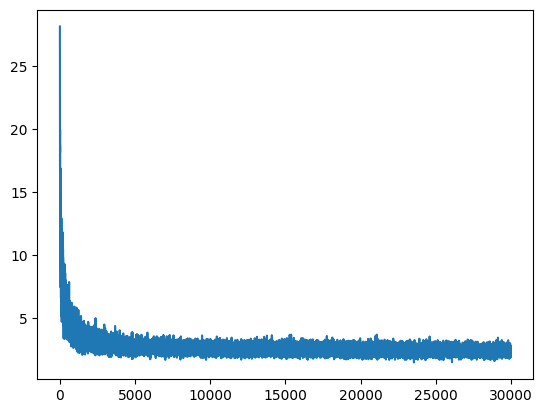

In [36]:
plt.plot(stepi, lossi)

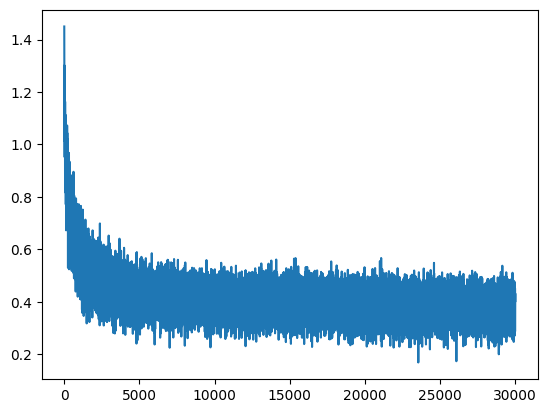

In [37]:
plt.plot(stepi, loglossi)

In [46]:
# forward on val set
emb = C[Xdev] # 32, 3, 2
h = torch.tanh(emb.view(-1, block_size * embed_dim) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss.item()

2.1851084232330322

In [238]:
# forward on val set
emb = C[X] # 32, 3, 2
h = torch.tanh(emb.view(-1, block_size * embed_dim) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Y)
loss.item()

2.2355165481567383

# 2D embedding plots

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


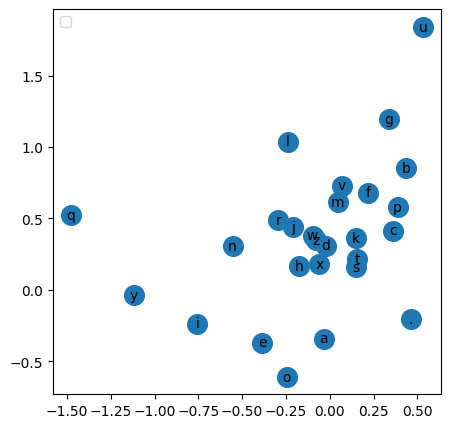

In [249]:
plt.figure(figsize=(5, 5))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)

for i in range(C.shape[0]):
    plt.text(C[i, 0].item(), C[i, 1].item(), itos[i], ha='center', va='center')
plt.legend()

# LRES

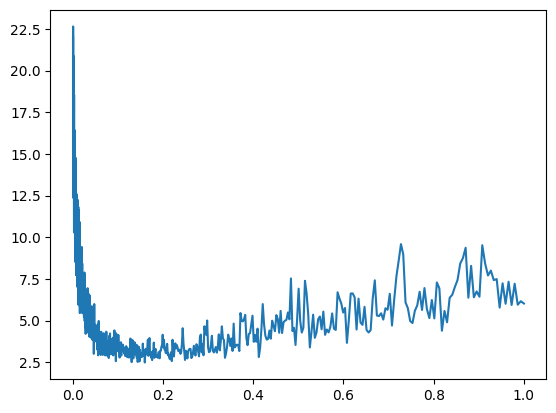

In [162]:
plt.plot(lris, lossis)

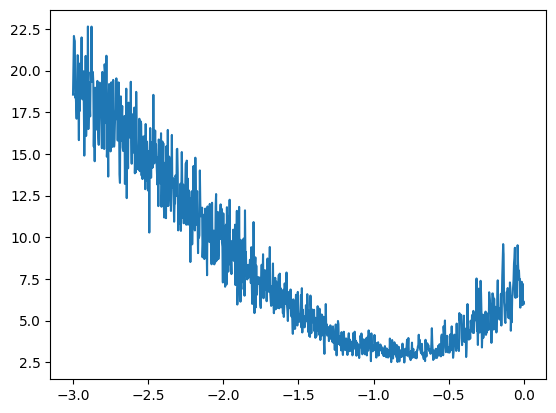

In [163]:
plt.plot(lres, lossis)

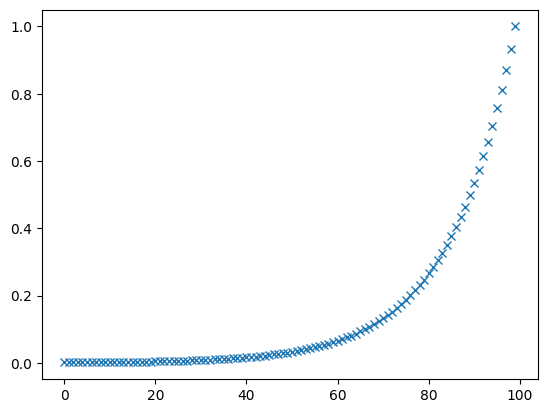

In [ ]:
plt.plot( lris, 'x')

# Sampling from the model

In [47]:
g = torch.Generator().manual_seed(2147483647 + 10)

for i in range(20):
    out = []
    context = [0] * block_size
    while 1:
        emb = C[torch.tensor(context)] 
        h = torch.tanh(emb.view(-1, block_size * embed_dim) @ W1 + b1)
        logits = h @ W2 + b2
        p = F.softmax(logits, dim=1)
        ix = torch.multinomial(p, 1, replacement=True, generator=g).item()
        out.append(itos[ix])
        context = context[1:] + [ix]
        if ix == 0:
            break

    print(''.join(out))

pry.
hareman.
maalma.
nalyla.
mugan.
lyuaron.
krisla.
woitalya.
sarcleon.
oltonev.
mackwaiem.
mika.
dataad.
roales.
alvosel.
abbiyan.
hadliyah.
crisa.
samena.
kai.


In [38]:
ix = torch.tensor([0, 0, 0])
C[ix]

tensor([[ 1.4517,  0.3131,  0.2457, -0.4979,  0.3074, -0.1897, -1.4769,  0.6407,
          0.0017,  1.1062],
        [ 1.4517,  0.3131,  0.2457, -0.4979,  0.3074, -0.1897, -1.4769,  0.6407,
          0.0017,  1.1062],
        [ 1.4517,  0.3131,  0.2457, -0.4979,  0.3074, -0.1897, -1.4769,  0.6407,
          0.0017,  1.1062]], grad_fn=<IndexBackward0>)